# Machine Learning & Computational Statistics

## Project: Hyperspectral image unmixing and pixel classification

----

> Kostis Konstantinos (p3352311) <br>
> MSc Data Science (Part-Time) <br>
> Athens University Of Economics and Business

In [1]:
# Import libraries

import scipy.io as sio
import numpy as np
import scipy.optimize

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

In [2]:
# seed for reproducibility
seed = 20241702
np.random.seed(seed)

## Data loading from matrices

In [3]:
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

## Plotting endmembers (materials)

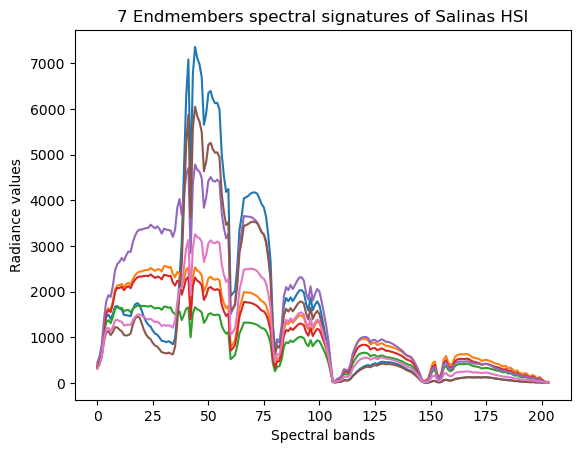

In [4]:
def plot_endmembers(endmembers):
    fig = plt.figure()
    plt.plot(endmembers)
    plt.ylabel('Radiance values')
    plt.xlabel('Spectral bands')
    plt.title('7 Endmembers spectral signatures of Salinas HSI')
    plt.show()

plot_endmembers(endmembers)

## Visualizing bands of salinas HSI

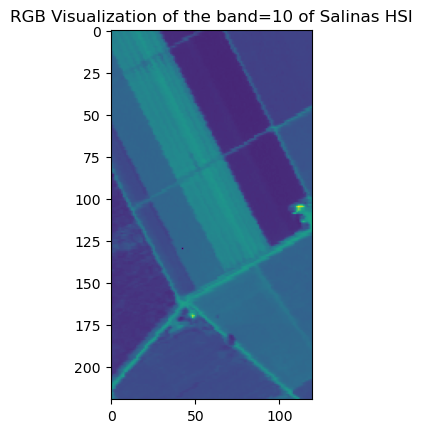

In [5]:
def visualize_band(img, band):
    fig = plt.figure()
    plt.imshow(img[:,:,band])
    plt.title("RGB Visualization of the band={} of Salinas HSI".format(band))
    plt.show()

visualize_band(HSI, 10)

In [6]:
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

# Part 1 (Spectral Unmixing)


The outline of this part is as follows:
- Define variables regarding the shape of data (pixels, length of spectral signature)
- Reshape the data (HSI and labels) in 2 dimensions for easier calculations.
- Define a method **abundance_map** which visualizes an endmember/material.
- Define a function **reconstruction_error** which implements the quantity $\lVert y_i - X\theta_i \rVert^2$
- For each unmixing method define the appropriate python method. These will be:
  - **LS** (The unconstrained ls)
  - **LS_sum_to_one** (For the sum to one constrained LS)
  - **LS_non_negative** (For the non-negative constrained LS)
  - **LS_nn_sum_to_one** (For the non-negative and sum to one constrained LS)
  - **lasso** (For the $L_1$ norm minimization of $\theta$)

## Reshaping and keeping pixels with non zero labels

In [7]:
# Retrieve the spatial and spectral length information
dimensions = HSI.shape
(M, N, SR, L) = (dimensions[0], dimensions[1], dimensions[0]*dimensions[1], dimensions[2])

# Reshape the data pixels into a 2D image
HSI_final = HSI.reshape(SR, L)

# Reshape the labels in 2D as an (M*N, 1) matrix
labels_final = labels.reshape((SR, 1))

# # Keep only the indices where the label is non-zero
# indices_to_keep = np.where(labels_reshaped[:, 0] > 0)[0]

# # Keep only the pixels (and the labels) that correspond to the
# # indices which are non-zero labels (found previously)
# HSI_final = HSI_reshaped[indices_to_keep]
# labels_final = labels_reshaped[indices_to_keep]

# # Retrieve again the spatial and spectral length information
# (SR, L) = sr_ssl(HSI_final)

## Methods for reconstruction error and abundance map visualization

In [8]:
# A constant mapping of endmembers indices to material_names
material_names = {
    1: 'Grapes',
    2: 'Broccoli',
    3: 'Fallow 1',
    4: 'Fallow 2',
    5: 'Fallow 3',
    6: 'Stubble',
    7: 'Celery'
}

# Compute the reconstruction error as defined in the exercise
# mean over pixel error, where pixel error is ||y_i - XΘ_i||**2
# by ignoring pixels with zero label
def reconstruction_error(y_true, y_predicted, labels):
    pixels = y_true.shape[0]
    errors = np.empty((0))

    for i in range(pixels):
        if labels[i, :][0] != 0:
            error = y_true[i, :] - y_predicted[i, :]
            errors = np.append(errors, [np.linalg.norm(error)**2])

    return np.mean(errors)

# Display a 2D image for every endmember that exists in the theta matrix
def abundance_maps(theta, M, N, material_names, su_method):
    materials = theta.shape[1]
    
    fig, axes = plt.subplots(1, materials, figsize=(10, 10))

    fig.set_figwidth(10)
    fig.set_figheight(10)
    fig.suptitle("Abundance maps for spectral unmixing, using method: {}".format(su_method))
    
    for m in range(materials):
        theta_m = theta[:, m].reshape(M, N)
        axes[m].imshow(theta_m)
        axes[m].set_title(material_names[m+1])
        axes[m].set_xticks([])
        axes[m].set_yticks([])

    plt.show()

## 1.a Unconstrained Least Squares

We start by using the least-squares without constraints, effectively implementing:

$y = X\theta + n \to \hat{\theta} = (X^TX)^{-1}X^Ty$

### Implementation

In [9]:
def LS(X, y, labels):
    theta = np.zeros((y.shape[0], X.shape[1]))

    for i in range(y.shape[0]):
        if labels[i, :][0] != 0:
            y_i = y[i, :]
            XTX_inv = np.linalg.inv(np.dot(X.T, X))
            theta[i, :] =  XTX_inv.dot(X.T).dot(y_i)

    return theta

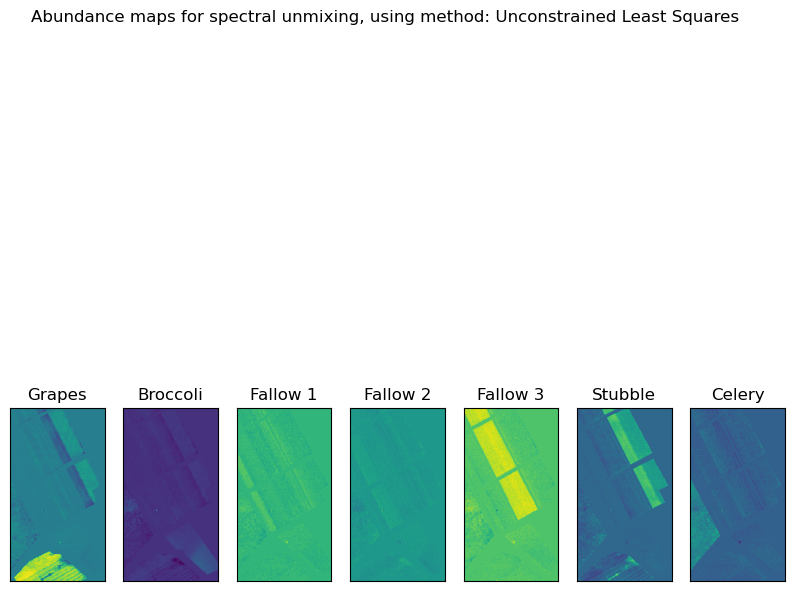

The reconstruction error using 'Unconstrained Least Squares' is: 35058.880662772644


In [10]:
su_method = 'Unconstrained Least Squares'

# Get the theta estimates for the unconstrained LS
theta_a = LS(endmembers, HSI_final, labels_final)

# Visualize the abundance maps
abundance_maps(theta_a, M, N, material_names, su_method)

# Perform predictions
predicted_a = np.dot(theta_a, endmembers.T)

# Get the reconstruction error
rc_error_a = reconstruction_error(HSI_final, predicted_a, labels_final)
print("The reconstruction error using '{}' is: {}".format(su_method, rc_error_a))

## 1.b Least squares imposing the sum-to-one constraint

In this question, we will use the scipy function optimization tooling in order to run least squares with
the constraint $\sum_{i=1}^{7}\theta_i = 1$

Specifically we will define:

- A function for minimization (objective function) which implements $Ax - b$
- The sum-to-one constraint on $\theta$ by utilizing python's lambda mechanism
- The initial theta as a vector of random normal weights.

The methodology is developed using the following resources:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
- https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp

### Implementation

In [11]:
def LS_sum_to_one(X, y, labels):

    # The objective function to minimize
    def objective_function(x, A, b):
        return np.linalg.norm(np.dot(A, x) - b)

    # The sum-to-one constraint
    constraints = ({'type': 'eq', 'fun': lambda parameters:  np.sum(parameters)-1})

    # Initial guess of a theta vector
    theta_init = np.random.normal(loc=0, scale=1, size=X.shape[1])

    # The theta matrix
    theta = np.zeros((y.shape[0], X.shape[1]))

    for i in range(y.shape[0]):
        if labels[i, :][0] != 0:
            result = scipy.optimize.minimize(
                objective_function,
                theta_init,
                args=(X, y[i, :]),
                constraints=constraints,
                method='SLSQP',
                tol=1e-6
            )
            theta[i, :] = result.x

    return theta

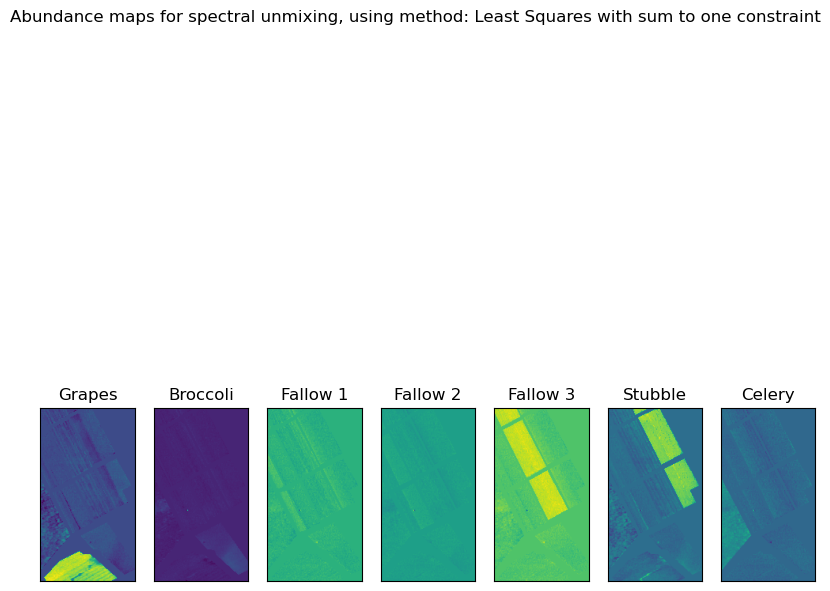

The reconstruction error using 'Least Squares with sum to one constraint' is: 43082.576338168095


In [12]:
su_method = 'Least Squares with sum to one constraint'

# Get the theta estimates for the sum-to-one constrained LS
theta_b = LS_sum_to_one(endmembers, HSI_final, labels_final)

# Visualize the abundance maps
abundance_maps(theta_b, M, N, material_names, su_method)

# Perform predictions
predicted_b = np.dot(theta_b, endmembers.T)

# Get the reconstruction error
rc_error_b = reconstruction_error(HSI_final, predicted_b, labels_final)
print("The reconstruction error using '{}' is: {}".format(su_method, rc_error_b))

## 1.c Least Squares imposing the non-negativity constraint on $\theta$

In this section the method **nnls** from SciPy will be used as instructed ([nnls documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls))

In [13]:
def LS_non_negative(X, y, labels):
    theta = np.zeros((y.shape[0], X.shape[1]))

    for i in range(y.shape[0]):
        if labels[i, :][0] != 0:
            y_i = y[i, :]
            x, rnorm = scipy.optimize.nnls(X, y_i)
            theta[i, :] = x

    return theta

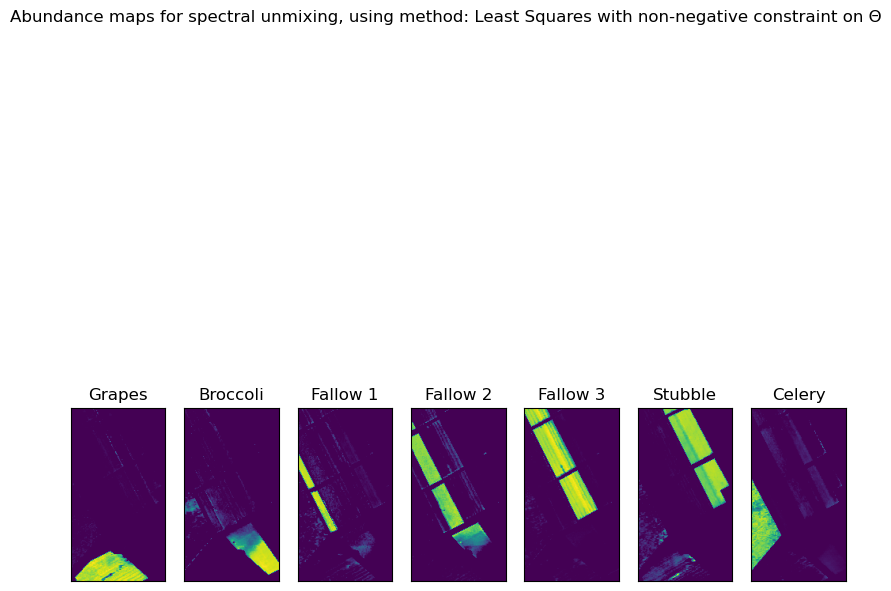

The reconstruction error using 'Least Squares with non-negative constraint on Θ' is: 156104.18220644674


In [14]:
su_method = 'Least Squares with non-negative constraint on Θ'

# Get the theta estimates for the non-negative constrained LS
theta_c = LS_non_negative(endmembers, HSI_final, labels_final)

# Visualize the abundance maps
abundance_maps(theta_c, M, N, material_names, su_method)

# Perform predictions
predicted_c = np.dot(theta_c, endmembers.T)

# Get the reconstruction error
rc_error_c = reconstruction_error(HSI_final, predicted_c, labels_final)
print("The reconstruction error using '{}' is: {}".format(su_method, rc_error_c))

## 1.d Least Squares imposing both non-negativity and sum-to-one constraint on $\theta$

In [15]:
def LS_nn_sum_to_one(X, y, labels):

    # The objective function to minimize
    def objective_function(x, A, b):
        return np.linalg.norm(np.dot(A, x) - b)

    # The sum-to-one constraint
    constraints = ({'type': 'eq', 'fun': lambda parameters:  np.sum(parameters)-1})

    # The non-nengative constraint (using bounds of scipy minimize)
    bounds = []
    for i in range(X.shape[1]):
        bounds.append((0, None))

    # Initial guess of a theta vector
    theta_init = np.random.normal(loc=0, scale=1, size=X.shape[1])

    # The theta matrix
    theta = np.zeros((y.shape[0], X.shape[1]))

    for i in range(y.shape[0]):
        if labels[i, :][0] != 0:
            result = scipy.optimize.minimize(
                objective_function,
                theta_init,
                args=(X, y[i, :]),
                constraints=constraints,
                bounds = bounds,
                method='SLSQP',
                tol=1e-6
            )
            theta[i, :] = result.x

    return theta

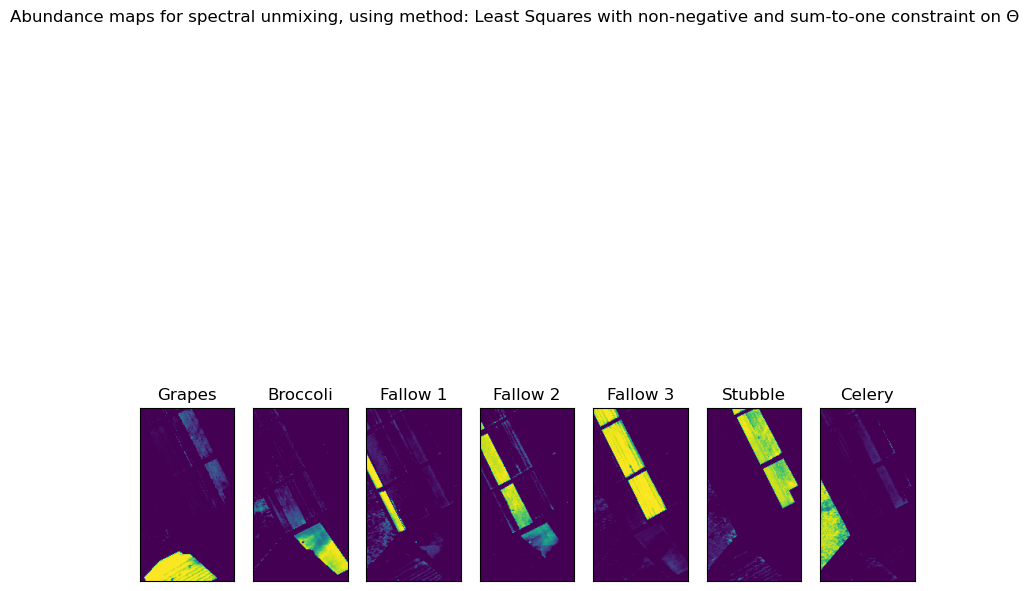

The reconstruction error using 'Least Squares with non-negative and sum-to-one constraint on Θ' is: 737977.6724285574


In [16]:
su_method = 'Least Squares with non-negative and sum-to-one constraint on Θ'

# Get the theta estimates for the non-negative and sum-to-one constrained LS
theta_d = LS_nn_sum_to_one(endmembers, HSI_final, labels_final)

# Visualize the abundance maps
abundance_maps(theta_d, M, N, material_names, su_method)

# Perform predictions
predicted_d = np.dot(theta_d, endmembers.T)

# Get the reconstruction error
rc_error_d = reconstruction_error(HSI_final, predicted_d, labels_final)
print("The reconstruction error using '{}' is: {}".format(su_method, rc_error_d))

## 1.e Lasso Regression (Imposing sparsity on $\theta$ via $L_1$ norm)

In this section the Scikit-Learn package will be used for the lasso regression

In [17]:
def lasso(X, y , labels):
    theta = np.zeros((y.shape[0], X.shape[1]))

    for i in range(y.shape[0]):
        if labels[i, :][0] != 0:
            y_i = y[i, :]

            regressor = Lasso(fit_intercept=False, max_iter=500_000)
            regressor.fit(X, y_i)

            theta[i, :] = regressor.coef_

    return theta

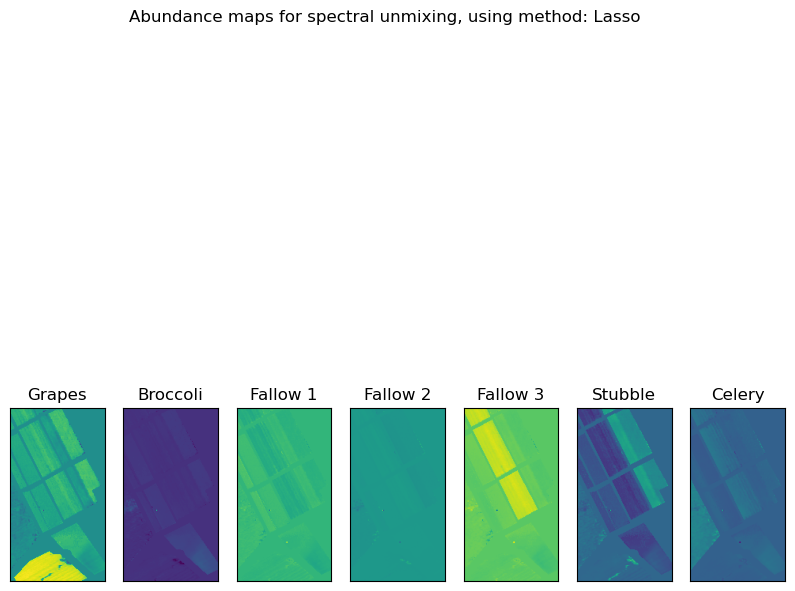

The reconstruction error using 'Lasso' is: 57855.889490840156


In [18]:
su_method = 'Lasso'

# Get the theta estimates for the Lasso
theta_e = lasso(endmembers, HSI_final, labels_final)

# Visualize the abundance maps
abundance_maps(theta_e, M, N, material_names, su_method)

# Perform predictions
predicted_e = np.dot(theta_e, endmembers.T)

# Get the reconstruction error
rc_error_e = reconstruction_error(HSI_final, predicted_e, labels_final)
print("The reconstruction error using '{}' is: {}".format(su_method, rc_error_e))

## B. Comparison of methods and comments 

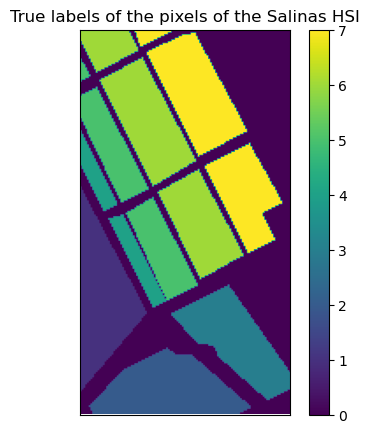

In [19]:
fig = plt.figure(figsize = (5,5))
plt.imshow(labels)
plt.title('True labels of the pixels of the Salinas HSI')
plt.colorbar()
plt.xticks(())
plt.yticks(())
plt.show()

1. Comparing the ground truth (labels) with the abundance maps of each of the five methods it is clear to see that
   the **Least Squares with non-negative and sum-to-one constraint** along with
   **Least Squares with non-negative constraint** methods are able to distinguish the 7 different classes pretty well.

2. Regarding the reconstruction errors we have:

   | Method | Reconstruction Error |
   |--------| ---------------------|
   | Unconstrained LS | 35058.880 |
   | LS with sum-to-one constraint| 43082.576 |
   | LS with non-negative constraint| 156104.182 |
   | LS with non-negative + sum-to-one constraint| 737977.672 |
   | Lasso | 57855.889 |

3. We can see that the more constraints we have, the greater the reconstruction error is.

4. The smallest errors were given by the methods of **Unconstrained LS** and **LS with sum-to-one constraint**, BUT these methods
   failed to clearly distinguish the 7 classes. Hence, it may be noted that the reconstruction error is not a valid metric to use
   in our study.

# Part 2 (Classification)

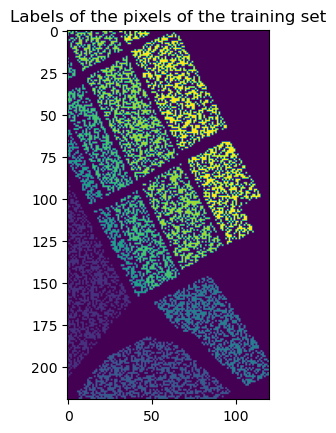

In [20]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

## Data preprocessing

This step precedes the classification ans is called data preprocessing. In this step we:
- reshape the labels as a column vector
- combine the HSI L-dimensional pixels (hence we use the 2D representation we created previously) with their respective labels
- ignore pixels with zero as label 

We perform these steps for training, test and operation set.

In [21]:
def preprocess(hsi_2d, data_labels):
    dataset_labels = data_labels.reshape(-1, 1).flatten()
    features = []
    targets = []

    for i in range(hsi_2d.shape[0]):
        if dataset_labels[i] != 0:
            features.append(hsi_2d[i, :])
            targets.append(dataset_labels[i])

    features = np.array(features)
    targets = np.array(targets)

    return (features, targets)

In [22]:
# apply the preprocess to all datasets
X_train, y_train = preprocess(HSI_final, Training_Set)
X_test, y_test = preprocess(HSI_final, Test_Set)
X_operational, y_operational = preprocess(HSI_final, Operational_Set)

### Confusion matrix and success rate

In [23]:
def performance(test_x, test_y, model):
    confusion_mat = confusion_matrix(test_y, model.predict(test_x))
    success_rate = np.trace(confusion_mat) / np.sum(confusion_mat)

    return confusion_mat, success_rate

def display_confusion_matrix(model, matrix):
    cm = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=model.classes_)
    cm.plot()

## A.1 Naive Bayes Classifier

### A.1.i) Training via 10-fold cross validation and report estimated validation error (and standard deviation)

In [24]:
gnb_cv_score = cross_val_score(GaussianNB(), X_train, y_train, cv=10)
gnb_cv_error = 1 - gnb_cv_score
gnb_cv_error_mean = round(gnb_cv_error.mean(), 5)
gnb_cv_error_std = round(gnb_cv_error.std(), 5)

print("(Gaussian) Naive Bayes has has a mean cross-validation error of: {}".format(gnb_cv_error_mean))
print("(Gaussian) Naive Bayes has has a std-dev cross-validation error of: {}".format(gnb_cv_error_std))

(Gaussian) Naive Bayes has has a mean cross-validation error of: 0.02622
(Gaussian) Naive Bayes has has a std-dev cross-validation error of: 0.01602


### A.1.ii) Training and performance evaluation

The success rate of (Gaussian) Naive Bayes is: 98.133%
Confusion Matrix of (Gaussian) Naive Bayes


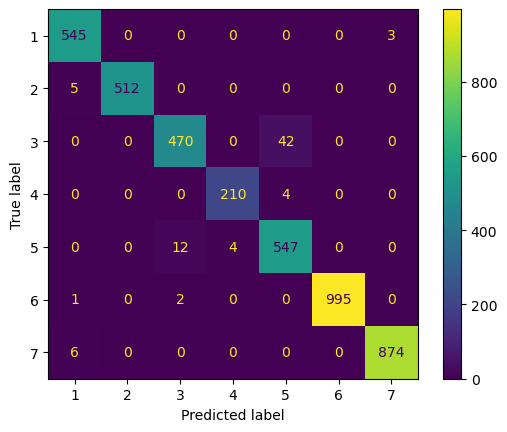

In [25]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

gnb_confusion_matrix, gnb_success_rate = performance(X_test, y_test, gnb_model)

print("The success rate of (Gaussian) Naive Bayes is: {}%".format(round(gnb_success_rate * 100.0, 3)))
print("Confusion Matrix of (Gaussian) Naive Bayes")
display_confusion_matrix(gnb_model, gnb_confusion_matrix)

## A.2 Minimum Euclidean Distance Classifier

I am implementing Minimum Euclidean Distance (MED) Classifier from scratch with a scikit-learn compatible interface, in order to easily use the **cross_val_score**
During the `fit()` a centroid is computed for every class. Then during `predict()` the given point is compared to each of the
centroids and the centroid with the smallest euclidean distnace from the point is selected.

$D(x, centroid) = \sqrt{\sum_{dim=1}^{N} (x_{dim} - centroid_{dim})^2}$

In [26]:
# Minimum Euclidean Distance Classifier (MED) implementation

class MEDClassifier:
    def __init__(self):
        self.centroids = {}

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes_ = np.unique(y).flatten()

        self._compute_centroids()

        return self

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def get_params(self, deep=True):
        """This classifier has no parameters"""
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def _compute_centroids(self):
        """Compute the centroid of every class."""
        for class_id in self.classes_:
            indices = np.argwhere(self.y == class_id)
            x_instances = self.X[indices]
            centroid = np.mean(x_instances, axis=0)
            self.centroids[class_id] = centroid

    def _predict(self, x):
        distances = {}

        for class_id in self.centroids.keys():
            class_centroid = self.centroids[class_id]
            distances[class_id] = self._euclidean_distance(x, class_centroid)

        assigned_class = sorted(distances.items(), key=lambda v: v[1])[0][0]
        return assigned_class

    def _euclidean_distance(self, v1, v2):
        return np.linalg.norm(v1-v2)

### A.2.i) Training via 10-fold cross validation and report estimated validation error (and standard deviation)

In [27]:
med_cv_score = cross_val_score(MEDClassifier(), X_train, y_train, cv=10, scoring='accuracy')
med_cv_error = 1 - med_cv_score
med_cv_error_mean = round(med_cv_error.mean(), 5)
med_cv_error_std = round(med_cv_error.std(), 5)

print("Minimum Euclidean Distance Classifier has a mean cross-validation error of: {}".format(med_cv_error_mean))
print("Minimum Euclidean Distance Classifier has a std-dev cross-validation error of: {}".format(med_cv_error_std))

Minimum Euclidean Distance Classifier has a mean cross-validation error of: 0.05508
Minimum Euclidean Distance Classifier has a std-dev cross-validation error of: 0.07682


### A.2.ii) Training and performance evaluation

The success rate of Min-Euclidean-Distance-Classifier is: 95.912%
Confusion Matrix of Min-Euclidean-Distance-Classifier


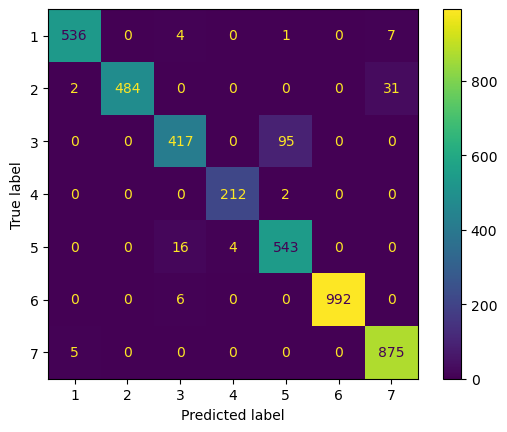

In [28]:
med_model = MEDClassifier()
med_model.fit(X_train, y_train)

med_confusion_matrix, med_success_rate = performance(X_test, y_test, med_model)

print("The success rate of Min-Euclidean-Distance-Classifier is: {}%".format(round(med_success_rate*100.0, 3)))
print("Confusion Matrix of Min-Euclidean-Distance-Classifier")
display_confusion_matrix(med_model, med_confusion_matrix)

## A.3 k-Nearest Neighbor Classifier

I am implementing K-NN from scratch with a scikit-learn compatible interface.
As a distance metric, the euclidean distance is used:
$D(a, b) = \sqrt{\sum_{dim=1}^{N} (a_{dim} - b_{dim})^2}$
via `np.linalg.norm`

In [29]:
class KNNClassifier:
    def __init__(self, k = 5):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes_ = np.unique(y).flatten()

        return self

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def get_params(self, deep=True):
        return {"k": self.k}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def _predict(self, x):
        distances = []

        for x_i in self.X:
            distances.append(self._euclidean_distance(x, x_i))
        
        nearest_indices = np.argsort(distances)[:self.k]
        labels = self.y[nearest_indices]
        values, counts = np.unique(labels, return_counts=True)
        return values[counts.argmax()]

    def _euclidean_distance(self, v1, v2):
        return np.linalg.norm(v1-v2)

### A.3.i) Training via 10-fold cross validation and report estimated validation error (and standard deviation)

In [30]:
knn_cv_score = cross_val_score(KNNClassifier(k=5), X_train, y_train, cv=10, scoring='accuracy')
knn_cv_error = 1 - knn_cv_score
knn_cv_error_mean = round(knn_cv_error.mean(), 5)
knn_cv_error_std = round(knn_cv_error.std(), 5)

print("K-NN Classifier has a mean cross-validation error of: {}".format(knn_cv_error_mean))
print("K-NN Classifier has has a std-dev cross-validation error of: {}".format(knn_cv_error_std))

K-NN Classifier has a mean cross-validation error of: 0.01808
K-NN Classifier has has a std-dev cross-validation error of: 0.02749


### A.3.ii) Training and performance evaluation

The success rate of k-Nearest Neighbors Classifier is: 99.598%
Confusion Matrix of k-Nearest Neighbors Classifier is:


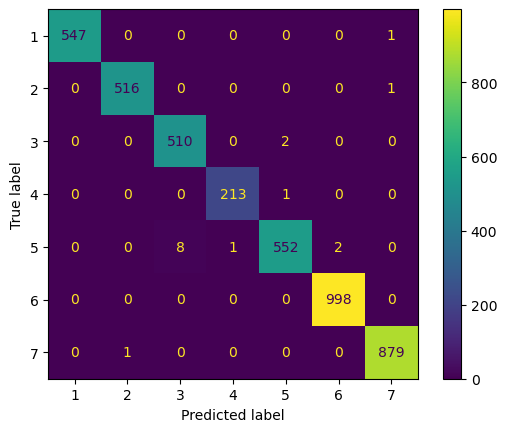

In [31]:
knn_model = KNNClassifier(k=5)
knn_model.fit(X_train, y_train)

knn_confusion_matrix, knn_success_rate = performance(X_test, y_test, knn_model)

print("The success rate of k-Nearest Neighbors Classifier is: {}%".format(round(knn_success_rate*100.0, 3)))
print("Confusion Matrix of k-Nearest Neighbors Classifier is:")
display_confusion_matrix(knn_model, knn_confusion_matrix)

## A.4 Bayesian Classifier

I implemented Bayes classifier from scratch, assuming a multivariate gaussian under the hood.
For each a class the `mean` vector and the `covariance` matrix are calculated along with the prior probability (`fit()`)
Then for classification the Bayes rule is used as $argmax_j P(\omega_j) * p(\omega_j | x)$ (`predict()`)

In [32]:
class BayesClassifier:
    def __init__(self):
        self.apriori_map = {}
        self.means_map = {}
        self.covariances_map = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y).flatten()
        self._calculate_apriori(y)
        self._calculate_gaussian_params(X, y)

        return self

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def get_params(self, deep=True):
        """This classifier has no parameters"""
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def _predict(self, x):
        g_x = {}

        for class_id in self.apriori_map.keys():
            prior = self.apriori_map[class_id]
            mu = self.means_map[class_id]
            cov = self.covariances_map[class_id]
            p_x = self._pdf(x, mu, cov)

            g_x[class_id] = prior * p_x

        assigned_class = sorted(g_x.items(), key=lambda x: -x[1])[0][0]
        return assigned_class

    def _calculate_apriori(self, y):
        classes = np.unique(y)
        for class_id in classes:
            self.apriori_map[class_id] = (y == class_id).sum() / len(y)

    def _calculate_gaussian_params(self, X, y):
        for class_id in self.apriori_map.keys():
            indices = np.argwhere(y == class_id).flatten()
            x_instances = X[indices]
            class_mean = np.mean(x_instances, axis=0)
            diff = x_instances - class_mean
            class_covariance = (diff.T @ diff) / len(x_instances)
            self.means_map[class_id] = class_mean
            self.covariances_map[class_id] = class_covariance

    def _pdf(self, x, mu, covariance):
        return multivariate_normal.pdf(x, mean=mu, cov=covariance)

### A.4.i) Training via 10-fold cross validation and report estimated validation error (and standard deviation)

In [33]:
b_cv_score = cross_val_score(BayesClassifier(), X_train, y_train, cv=10, scoring='accuracy')
b_cv_error = 1 - b_cv_score
b_cv_error_mean = round(b_cv_error.mean(), 5)
b_cv_error_std = round(b_cv_error.std(), 5)

print("Bayesian Classifier has a mean cross-validation error of: {}".format(b_cv_error_mean))
print("Bayesian Classifier has has a std-dev cross-validation error of: {}".format(b_cv_error_std))

Bayesian Classifier has a mean cross-validation error of: 0.10766
Bayesian Classifier has has a std-dev cross-validation error of: 0.13661


### A.4.ii) Training and performance evaluation

The success rate of Bayesian Classifier is: 97.566%
Confusion Matrix of Bayesian Classifier


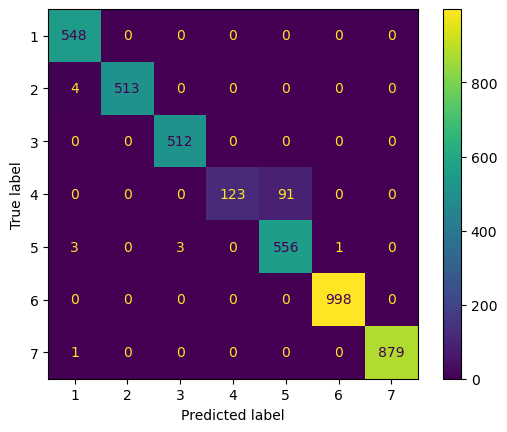

In [34]:
b_model = BayesClassifier()
b_model.fit(X_train, y_train)

b_confusion_matrix, b_success_rate = performance(X_test, y_test, b_model)

print("The success rate of Bayesian Classifier is: {}%".format(round(b_success_rate * 100.0, 3)))
print("Confusion Matrix of Bayesian Classifier")
display_confusion_matrix(b_model, b_confusion_matrix)

## B. Comparison of classifiers results

### Regarding the success rates

| Classifier  | Package/Implementation | Success Rate (On Test Set)| Cross-Validation Error Mean | Cross-Validation Error StDev |
| ------------| ---------------------- |--------------| --------------------------- | ---------------------------- |
| Naive Bayes | Scikit-Learn           | 98.13%       | 1.808%                      | 1.602%                       |
| Min Euclidean Distance | From Scratch           | 95.91%       |         5.508%             |          7.682%           |
| k-Nearest-Neighbors (k=5) | From Scratch           | 99.598%       | 1.808%                      | 2.749%                      |
| Bayes | From Scratch           | 97.566%      | 10.76%                     | 13.66%                      |

### Regarding the confusion matrices (notable observations)

- Naive bayes: In class 3 we can see that this classifier confuses 42 instances and classifies them as class 5. This may be
  normal since both elements (class 3 and 5) are fallow elements (fallow 1 and 3 respectively) hence they may be similar and
  hard to distinguish.
- Min Euclidean Distance: Again, this classifier in class 3, confuses 95 instances as class 5.
- K-NN: Without doubt this is a near perfect classifier achieving 99.6% success rate, missclassifying only 17 instances in total.
- Bayes: In class 4 we can see that this classifier confuses 91 instances and classifies them as class 5 (fallow-2 are confused
  as fallow-3 respectively)

## Making predictions on the operational set (for completeness reasons)

In a real system setup we do not know the true labels of the operational set.
Nevertheless, since we have an operational set here with known labels we perform inference and calculate
the success rate and confusion matrix, using the best classifier which is k-NN (k=5)

The success rate of k-NN Classifier (on the operational set) is: 97.921%
Confusion Matrix of k-NN Classifier (on the operational set)


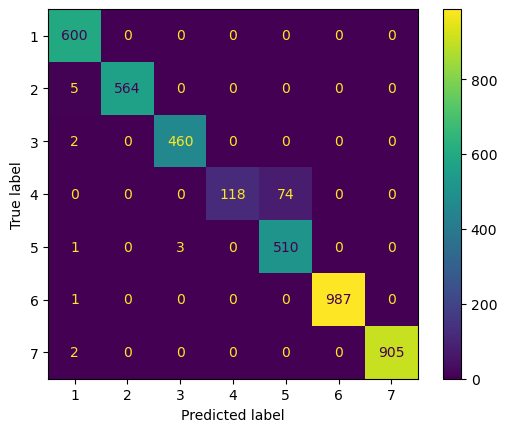

In [35]:
knn_opset_confusion_matrix, knn_opset_success_rate = performance(X_operational, y_operational, b_model)

print("The success rate of k-NN Classifier (on the operational set) is: {}%".format(round(knn_opset_success_rate * 100.0, 3)))
print("Confusion Matrix of k-NN Classifier (on the operational set)")
display_confusion_matrix(knn_model, knn_opset_confusion_matrix)

# Part 3 (Combination)

In Part 1 of the project, we applied **regression** algorithms for spectral unmixing. Each of the methods used, produced abundance maps which helped understand how the separate classes look like.
If we think about it, this methodology of spectral unmixing actually tries to separate the components of a pixel (called endmembers) and tries to find the major contributor.
Essentially it performs classification, in our case.

In Part 2 of the project, we simply applied **classification** algorithms in order to assign each pixel to the correct class (aka an endmember)

So, in our case (spectral unmixing) regression and classification are correlated. But, there is point in using both in our case because evidently classificationworked remarkably well
achieving a 99.5% success rate using k-Nearest Neighbors(k=5) and actually worked better than the regression task.

In other systems perhaps, where both methodologies may not work exceptionally well, the idea of combining the two might increase the overall system accuracy!